In [36]:
# Import needed libraries
import cv2  # Import OpenCV library for image processing
import numpy as np  # Import NumPy library for numerical operations
import matplotlib.pyplot as plt  # Import Matplotlib library for plotting
import random  # Import random library for random sampling
import argparse  # Import argparse library for command line argument parsing


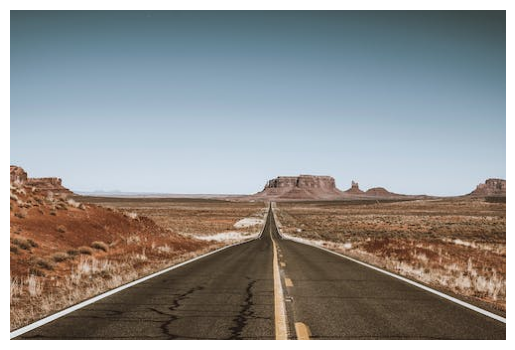

In [39]:
# Load images from a file path
def load_images(filename):
    try:
        img = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)  # Read the image file using OpenCV and convert it to RGB color space
        return img
    except IOError:
        print("File is not an image\n")
        exit()

# Display the image
def show_images(image):
    plt.figure()
    plt.imshow(image, cmap='gray')  # Display the image using Matplotlib with the 'gray' colormap
    plt.axis('off')  # Turn off the axis labels
    plt.show()

image_path = '/content/pexels-photo-10622719.jpeg'  # Set the path to the image file
image = load_images(image_path)  # Load the image from the specified path
show_images(image)  # Display the loaded image


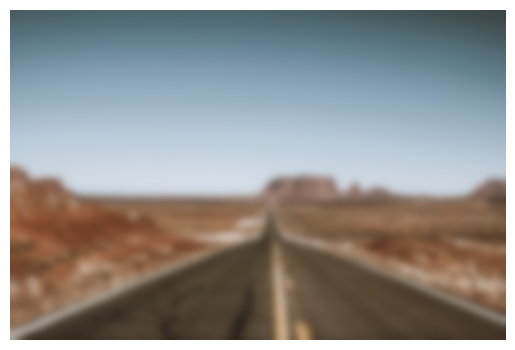

In [40]:
def apply_blur(image):
    # Create a Gaussian kernel with size 70 and standard deviation 4
    gau_kernel = cv2.getGaussianKernel(70, 4)
    
    # Create a 2D Gaussian kernel by taking the outer product of the 1D kernel with itself
    gau_kern2d = np.outer(gau_kernel, gau_kernel)
    
    # Normalize the 2D Gaussian kernel so that the sum of all elements is 1
    gau_kern2d = gau_kern2d / gau_kern2d.sum()
    
    # Apply the Gaussian blur to the image using the 2D kernel
    blur_image = cv2.filter2D(image, -1, gau_kern2d)
    
    return blur_image

# Apply Gaussian blur to the image
blur_image = apply_blur(image)

# Display the blurred image
show_images(blur_image)

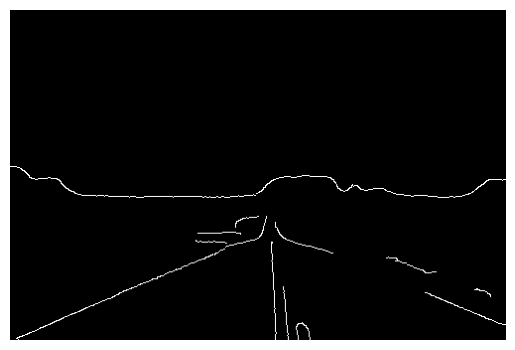

In [41]:
def apply_canny(blur_image):
    # Apply Canny edge detection to the blurred image
    # Canny edge detection algorithm detects edges in an image by applying gradient calculations and thresholding
    # The parameters used here are: low threshold = 40, high threshold = 70, aperture size = 3, L2 gradient calculation
    edge_image = cv2.Canny(blur_image, 40, 70, apertureSize=3, L2gradient=True)
    return edge_image

# Apply Canny edge detection to the blurred image
edge_image = apply_canny(blur_image)

# Display the edge image
plt.figure()
plt.imshow(edge_image, cmap='gray')
plt.axis('off')
plt.show()

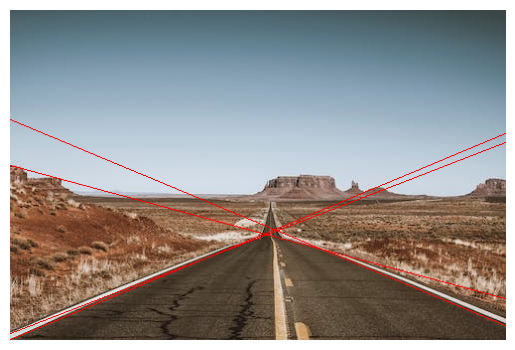

In [42]:
# Function to detect lines in an edge-detected image using Hough Transform
def detect_lines(edge_image):
    # Apply Hough Transform to detect lines in the edge-detected image
    lines = cv2.HoughLines(edge_image, 1, np.pi / 120, 55)
    
    # Initialize a list to store valid lines
    valid_lines = []
    
    # Check if any lines were detected
    if lines is not None:
        for line in lines:
            rho, theta = line[0]  # Unpack the line parameters: rho (distance from origin) and theta (angle)
            
            # Filter out lines based on their orientation (theta)
            # Only keep lines that are roughly vertical or horizontal (not parallel to the image axes)
            if (theta > 0.4 and theta < 1.47) or (theta > 1.67 and theta < 2.74):
                valid_lines.append(line)  # Append valid lines to the list
    
    return valid_lines  # Return the list of valid lines

# Detect lines from the edge-detected image
lines = detect_lines(edge_image)

# Function to draw lines on the original image
def show_lines(image, lines):
    for line in lines:
        rho, theta = line[0]  # Unpack the line parameters: rho and theta
        
        # Calculate the line's end points in Cartesian coordinates
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        
        # Define points for drawing the line (extend line to cover the image)
        pt1 = (int(x0 + 1000 * (-b)), int(y0 + 1000 * (a)))
        pt2 = (int(x0 - 1000 * (-b)), int(y0 - 1000 * (a)))
        
        # Draw the line on the image (color = red, thickness = 1 pixel)
        cv2.line(image, pt1, pt2, (255, 0, 0), 1)
    
    # Show the image with the drawn lines
    show_images(image)

# Check if lines were detected before trying to draw them
if lines:
    # If lines were detected, draw them on the original image and show the result
    show_lines(image, lines)
else:
    # If no lines were detected, print a message indicating this
    print("No lines detected.")


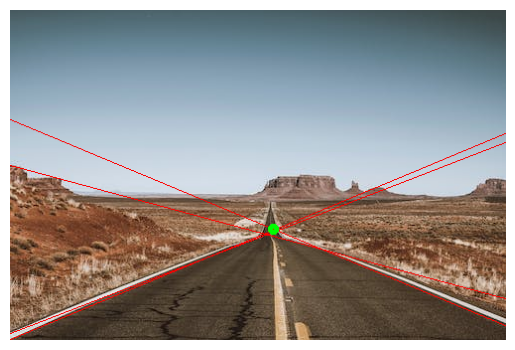

Vanishing Point found at: (265, 221)


In [43]:
# Find Intersection Point
def find_intersection_point(line1, line2):
    # Extract rho and theta for both lines
    rho1, theta1 = line1[0]
    rho2, theta2 = line2[0]
    
    # Form matrix A and vector b to solve the system of linear equations
    A = np.array([[np.cos(theta1), np.sin(theta1)], [np.cos(theta2), np.sin(theta2)]])
    b = np.array([rho1, rho2])
    
    # Calculate the determinant of A to check if the lines are not parallel
    det_A = np.linalg.det(A)
    if det_A != 0:
        # Solve for intersection point (x0, y0) using numpy's linear algebra solver
        x0, y0 = np.linalg.solve(A, b)
        return int(np.round(x0)), int(np.round(y0))  # Return rounded intersection point as integers
    return None  # Return None if lines are parallel or intersecting point cannot be determined

# Find Distance from a Point to a Line
def find_dist_to_line(point, line):
    # Extract x and y coordinates of the point
    x0, y0 = point
    
    # Extract rho and theta for the line
    rho, theta = line[0]
    
    # Calculate the slope (m) and intercept (c) of the line in y = mx + c form
    m = (-1 * np.cos(theta)) / np.sin(theta)
    c = rho / np.sin(theta)
    
    # Calculate the intersection point between the line and the perpendicular from the point
    x = (x0 + m * y0 - m * c) / (1 + m ** 2)
    y = (m * x0 + (m ** 2) * y0 - (m ** 2) * c) / (1 + m ** 2) + c
    
    # Compute the Euclidean distance between the point and the intersection point
    dist = np.sqrt((x - x0) ** 2 + (y - y0) ** 2)
    return dist

# RANSAC to find Vanishing Point
def RANSAC(lines, ransac_iterations, ransac_threshold, ransac_ratio):
    inlier_count_ratio = 0.0  # Initialize ratio of inliers
    vanishing_point = (0, 0)  # Initialize vanishing point
    
    for iteration in range(ransac_iterations):
        # Check if there are enough lines to sample
        if len(lines) < 2:
            break
        
        # Randomly select 2 lines from the list
        selected_lines = random.sample(lines, 2)
        line1, line2 = selected_lines[0], selected_lines[1]
        
        # Compute the intersection point of the selected lines
        intersection_point = find_intersection_point(line1, line2)
        
        if intersection_point is not None:
            # Count the number of lines whose distance to the intersection point is less than the threshold
            inlier_count = sum(find_dist_to_line(intersection_point, line) < ransac_threshold for line in lines)
            
            # Update vanishing point if the ratio of inliers is higher than the previous best
            if inlier_count / float(len(lines)) > inlier_count_ratio:
                inlier_count_ratio = inlier_count / float(len(lines))
                vanishing_point = intersection_point
            
            # If the number of inliers exceeds the ratio threshold, break the loop
            if inlier_count > len(lines) * ransac_ratio:
                break
    
    return vanishing_point

# Define RANSAC parameters
ransac_iterations, ransac_threshold, ransac_ratio = 350, 13, 0.93

# Apply RANSAC to find the vanishing point
vanishing_point = RANSAC(lines, ransac_iterations, ransac_threshold, ransac_ratio)

# Plot vanishing point on original image
def show_point(image, point):
    if point is not None:
        # Draw a circle at the vanishing point on the image
        cv2.circle(image, point, 3, (0, 255, 0), thickness=3)
        
        # Display the image with the vanishing point marked
        show_images(image)
        
        # Print the coordinates of the vanishing point
        print(f"Vanishing Point found at: {point}")
    else:
        # Inform that no vanishing point was found
        print("No vanishing point found.")

# Show the image with the vanishing point
show_point(image, vanishing_point)